## Mutual Informormation - Find Best K for LM Model"""


/home/mlyang721/miniconda3/envs/fast/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyzing Mutual Information for Llama-2-70b-chat responses...


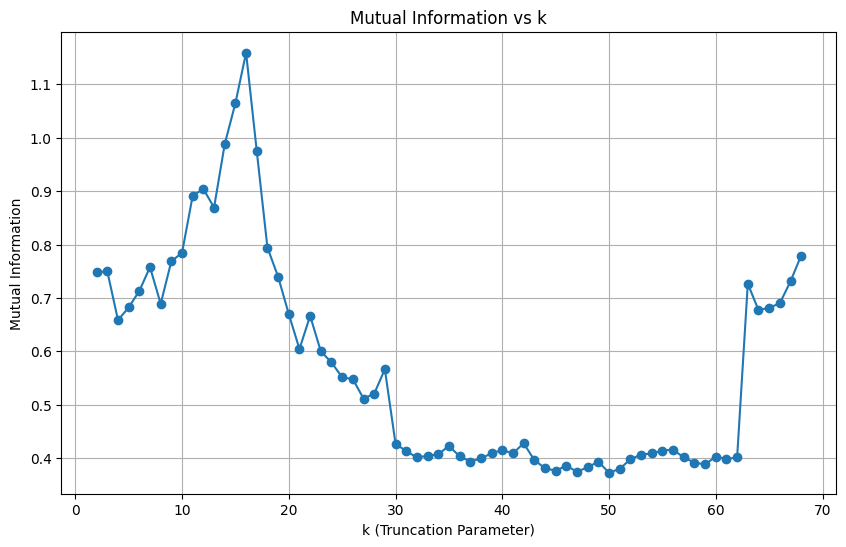

In [ ]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from math import sqrt
import matplotlib.pyplot as plt

# Paths to local files
questions_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/question.jsonl"
llama2_70b_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/Llama-2-70b-chat.jsonl"

# Function to read JSONL files
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Compute probabilities for full and truncated context
def compute_probabilities(model, tokenizer, context, target, k):
    max_length = tokenizer.model_max_length  # Get the max sequence length for the model
    truncated_context = " ".join(context.split()[-k:])  # Truncate to last k tokens

    # Tokenize and truncate
    full_input_ids = tokenizer(context, return_tensors="pt", truncation=True, max_length=max_length).input_ids
    truncated_input_ids = tokenizer(truncated_context, return_tensors="pt", truncation=True, max_length=max_length).input_ids

    with torch.no_grad():
        full_logits = model(full_input_ids).logits
        truncated_logits = model(truncated_input_ids).logits

    full_probs = torch.softmax(full_logits[0, -1], dim=-1)
    truncated_probs = torch.softmax(truncated_logits[0, -1], dim=-1)

    return full_probs, truncated_probs

# Compute mutual information (from KL divergence)
def compute_mutual_information(prob_full, prob_truncated):
    """
    Compute mutual information as the KL divergence between P_full and P_truncated.
    """
    kl_divergence = torch.sum(prob_full * torch.log(prob_full / prob_truncated)).item()
    return kl_divergence  # MI = KL divergence

# Analyze mutual information for questions and responses
def analyze_mutual_information(questions, responses, model, tokenizer):
    combined_text = []
    max_length = 0

    # Combine all questions and responses
    for question in questions:
        question_id = question["question_id"]
        question_turns = " ".join(question["turns"])  # Combine all turns of the question

        # Find the response for the current question ID
        response = next((r for r in responses if r["question_id"] == question_id), None)
        if response:
            response_turns = " ".join(response["choices"][0]["turns"])  # Combine all turns of the response
            combined = question_turns + " " + response_turns
            combined_text.append(combined)
            max_length = max(max_length, len(combined.split()))

    # Use the longest context to calculate k range
    context = " ".join(combined_text)
    target = context.split()[-1]
    k_max = min(int(sqrt(max_length)), tokenizer.model_max_length)
    k_values = range(2, k_max + 1)

    mutual_information = []
    for k in k_values:
        prob_full, prob_truncated = compute_probabilities(model, tokenizer, context, target, k)
        mi = compute_mutual_information(prob_full, prob_truncated)
        mutual_information.append(mi)

    # Plot Mutual Information vs k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mutual_information, marker='o', linestyle='-')
    plt.xlabel("k (Truncation Parameter)")
    plt.ylabel("Mutual Information")
    plt.title("Mutual Information vs k")
    plt.grid()
    plt.show()

# Load the datasets
questions = read_jsonl(questions_path)
llama2_70b_responses = read_jsonl(llama2_70b_path)

# Load the Hugging Face model and tokenizer
model_name = "gpt2"  # You can use a larger model if available
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Analyze Mutual Information for Llama-2-70b responses
print("Analyzing Mutual Information for Llama-2-70b-chat responses...")
analyze_mutual_information(questions, llama2_70b_responses, model, tokenizer)


Analyzing Mutual Information for GPT-3.5-turbo responses...


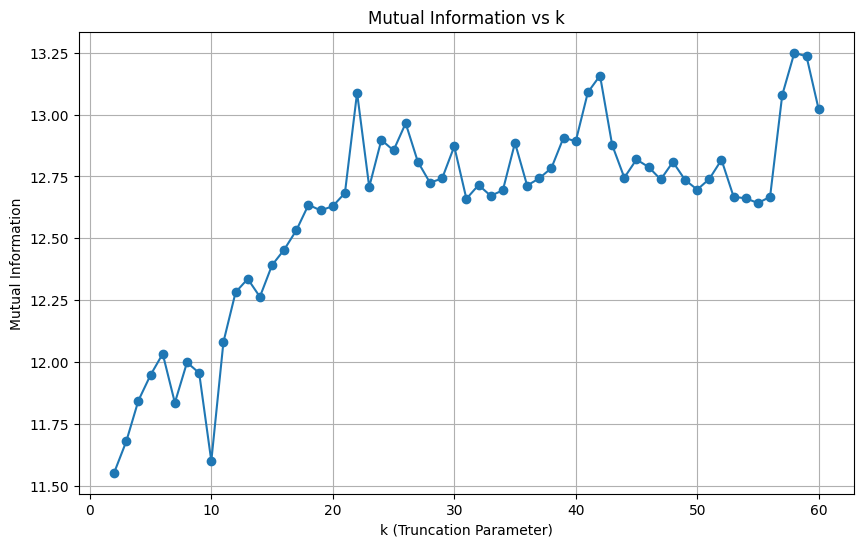

Analyzing Mutual Information for GPT-4 responses...


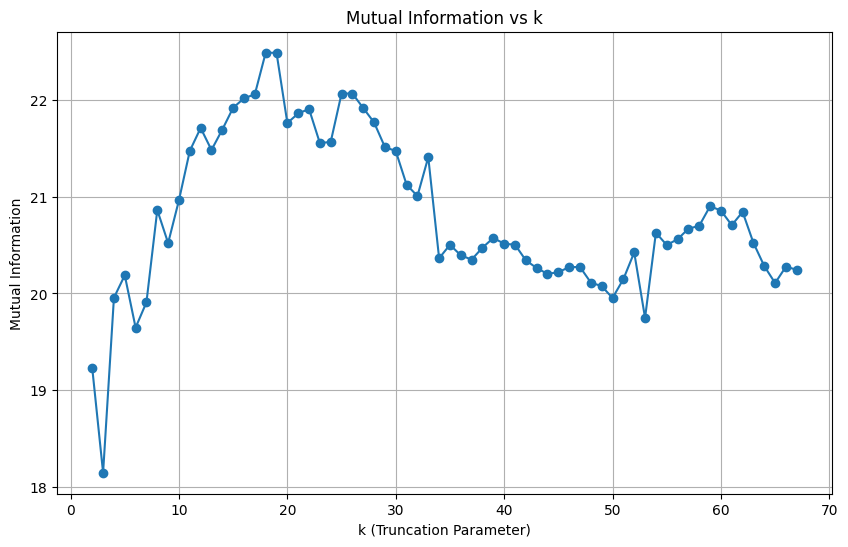

In [2]:
# Paths to new response files
gpt35_turbo_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-3.5-turbo.jsonl"
gpt4_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-4.jsonl"

# Load the additional datasets
gpt35_turbo_responses = read_jsonl(gpt35_turbo_path)
gpt4_responses = read_jsonl(gpt4_path)

# Analyze Mutual Information for GPT-3.5-turbo responses
print("Analyzing Mutual Information for GPT-3.5-turbo responses...")
analyze_mutual_information(questions, gpt35_turbo_responses, model, tokenizer)

# Analyze Mutual Information for GPT-4 responses
print("Analyzing Mutual Information for GPT-4 responses...")
analyze_mutual_information(questions, gpt4_responses, model, tokenizer)


## PMI Methods, not as good as MI


/home/mlyang721/miniconda3/envs/fast/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyzing PMI Difference for Llama-2-70b-chat responses...


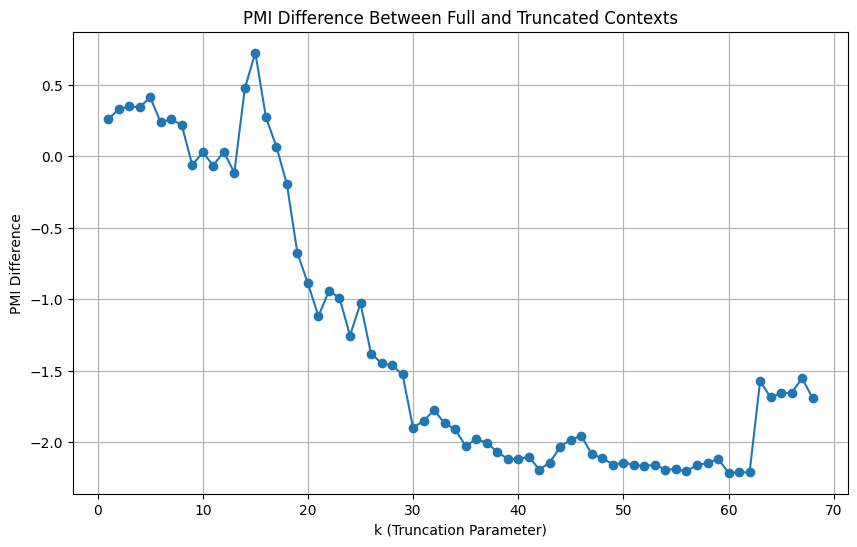

In [1]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from math import sqrt
import matplotlib.pyplot as plt

# Paths to local files
questions_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/question.jsonl"
llama2_70b_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/Llama-2-70b-chat.jsonl"

# Function to read JSONL files
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Compute probabilities for full and truncated contexts
def compute_probabilities(model, tokenizer, context, target, k):
    max_length = tokenizer.model_max_length
    truncated_context = " ".join(context.split()[-k:])  # Truncate to last k tokens

    # Tokenize and truncate
    full_input_ids = tokenizer(context, return_tensors="pt", truncation=True, max_length=max_length).input_ids
    truncated_input_ids = tokenizer(truncated_context, return_tensors="pt", truncation=True, max_length=max_length).input_ids

    with torch.no_grad():
        full_logits = model(full_input_ids).logits
        truncated_logits = model(truncated_input_ids).logits

    # Get probabilities for the target token
    full_probs = torch.softmax(full_logits[0, -1], dim=-1)
    truncated_probs = torch.softmax(truncated_logits[0, -1], dim=-1)

    return full_probs, truncated_probs

# Compute PMI for a given context
def compute_pmi(prob_context, prob_marginal):
    """
    Compute PMI as log(P(W_t | Context) / P(W_t)).
    """
    return torch.log(prob_context / prob_marginal).item()

# Analyze PMI difference for questions
def analyze_pmi_difference(questions, responses, model, tokenizer):
    combined_text = []
    max_length = 0

    # Combine all questions and responses
    for question in questions:
        question_id = question["question_id"]
        question_turns = " ".join(question["turns"])  # Combine all turns of the question

        # Find the response for the current question ID
        response = next((r for r in responses if r["question_id"] == question_id), None)
        if response:
            response_turns = " ".join(response["choices"][0]["turns"])  # Combine all turns of the response
            combined = question_turns + " " + response_turns
            combined_text.append(combined)
            max_length = max(max_length, len(combined.split()))

    # Use the longest context to calculate k range
    context = " ".join(combined_text)
    target = context.split()[-1]  # Last word is the target
    k_max = min(int(2 * sqrt(max_length)), tokenizer.model_max_length)
    k_values = range(1, k_max + 1)

    pmi_differences = []
    marginal_probs = None  # Lazy evaluation to compute marginal probabilities once

    for k in k_values:
        prob_full, prob_truncated = compute_probabilities(model, tokenizer, context, target, k)

        # Compute marginal probabilities if not already done
        if marginal_probs is None:
            marginal_probs = torch.mean(prob_full)  # Approximate P(W_t) as the mean over vocabulary

        # Compute PMIs
        pmi_full = compute_pmi(prob_full[tokenizer.convert_tokens_to_ids(target)], marginal_probs)
        pmi_truncated = compute_pmi(prob_truncated[tokenizer.convert_tokens_to_ids(target)], marginal_probs)

        # Calculate PMI difference
        pmi_difference = pmi_full - pmi_truncated
        pmi_differences.append(pmi_difference)

    # Plot PMI Differences
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, pmi_differences, marker='o', linestyle='-')
    plt.xlabel("k (Truncation Parameter)")
    plt.ylabel("PMI Difference")
    plt.title("PMI Difference Between Full and Truncated Contexts")
    plt.grid()
    plt.show()

# Load datasets
questions = read_jsonl(questions_path)
llama2_70b_responses = read_jsonl(llama2_70b_path)

# Load Hugging Face model and tokenizer
model_name = "gpt2"  # You can use a larger model if available
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Analyze PMI Difference for Llama-2-70b responses
print("Analyzing PMI Difference for Llama-2-70b-chat responses...")
analyze_pmi_difference(questions, llama2_70b_responses, model, tokenizer)


Analyzing Mutual Information for GPT-3.5-turbo responses...


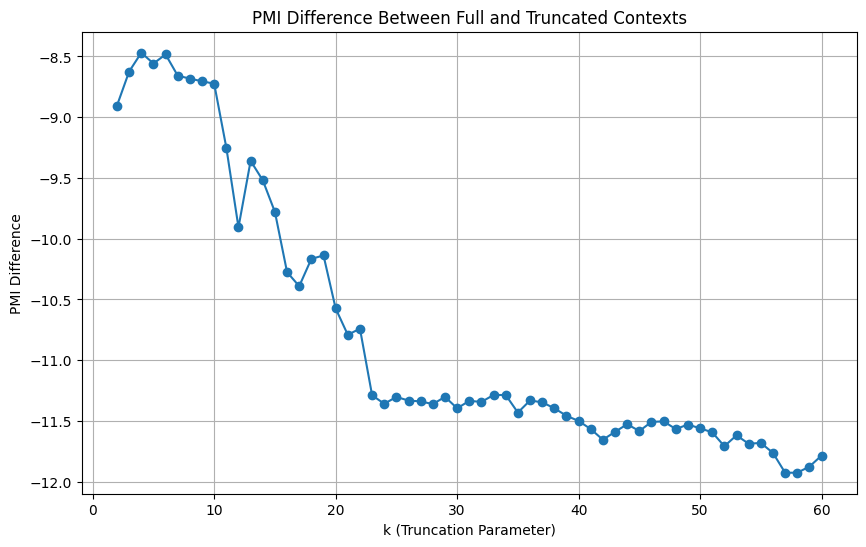

Analyzing Mutual Information for GPT-4 responses...


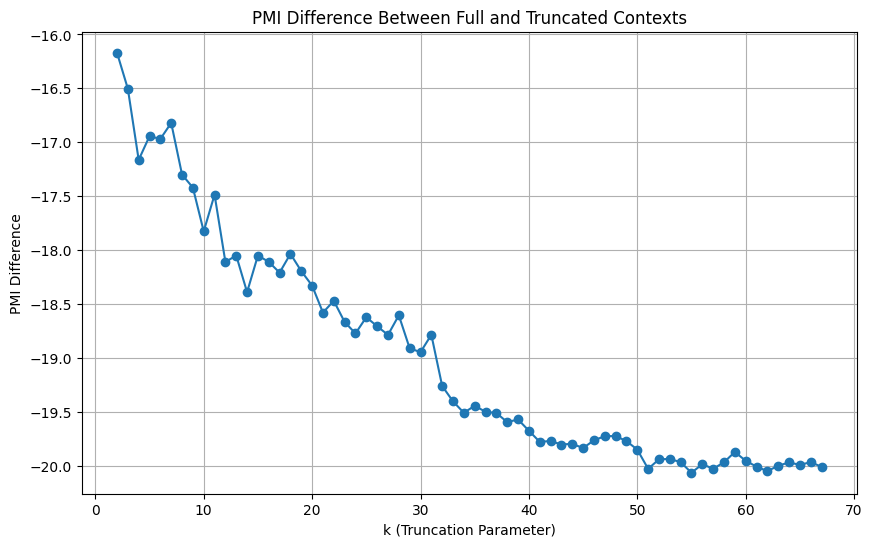

In [2]:
# Paths to new response files
gpt35_turbo_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-3.5-turbo.jsonl"
gpt4_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-4.jsonl"

# Load the additional datasets
gpt35_turbo_responses = read_jsonl(gpt35_turbo_path)
gpt4_responses = read_jsonl(gpt4_path)

# Analyze Mutual Information for GPT-3.5-turbo responses
print("Analyzing Mutual Information for GPT-3.5-turbo responses...")
analyze_pmi_difference(questions, gpt35_turbo_responses, model, tokenizer)

# Analyze Mutual Information for GPT-4 responses
print("Analyzing Mutual Information for GPT-4 responses...")
analyze_pmi_difference(questions, gpt4_responses, model, tokenizer)


## AIC && BIC

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from math import log, exp

# Load dataset
questions_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/question.jsonl"
responses_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/Llama-2-70b-chat.jsonl"

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

questions = read_jsonl(questions_path)
responses = read_jsonl(responses_path)

# Count n-grams and distinct contexts
def count_ngrams_and_contexts(tokens, k):
    ngram_counts = defaultdict(int)
    prefix_counts = defaultdict(int)
    continuation_counts = defaultdict(int)
    distinct_contexts = defaultdict(set)

    for t in range(k, len(tokens)):
        ngram = tuple(tokens[t-k:t+1])  # (W_{t-k}, ..., W_t)
        prefix = tuple(tokens[t-k:t])  # (W_{t-k}, ..., W_{t-1})
        word = tokens[t]              # W_t
        ngram_counts[ngram] += 1
        prefix_counts[prefix] += 1
        distinct_contexts[word].add(prefix)  # Track distinct contexts for W_t

    # Count unique contexts for each word
    for word, contexts in distinct_contexts.items():
        continuation_counts[word] = len(contexts)

    return ngram_counts, prefix_counts, continuation_counts

# Compute Kneser-Ney probability
def compute_kneser_ney_probability(ngram_counts, prefix_counts, continuation_counts, ngram, D, vocab_size):
    prefix = ngram[:-1]
    word = ngram[-1]

    # Higher-order probability
    count_ngram = ngram_counts[ngram]
    count_prefix = prefix_counts[prefix]
    higher_order_prob = max(count_ngram - D, 0) / count_prefix if count_prefix > 0 else 0

    # Continuation probability
    continuation_prob = continuation_counts[word] / sum(continuation_counts.values())

    # Backoff weight
    backoff_weight = (D / count_prefix) * len([ng for ng in ngram_counts if ng[:-1] == prefix]) if count_prefix > 0 else 1

    # Combine higher-order and continuation probabilities
    return higher_order_prob + backoff_weight * continuation_prob

# Compute log-likelihood using Kneser-Ney smoothing
def compute_log_likelihood_kn(tokens, k, D):
    ngram_counts, prefix_counts, continuation_counts = count_ngrams_and_contexts(tokens, k)
    log_likelihood = 0

    for t in range(k, len(tokens)):
        ngram = tuple(tokens[t-k:t+1])  # (W_{t-k}, ..., W_t)
        prob = compute_kneser_ney_probability(ngram_counts, prefix_counts, continuation_counts, ngram, D, vocab_size)
        log_likelihood += log(prob)

    return log_likelihood

# Calculate AIC and BIC in log-space
def calculate_bic_aic_log(tokens, max_k, D):
    k_values = range(2, max_k + 1)
    aic_values = []
    bic_values = []

    for k in k_values:
        log_likelihood = compute_log_likelihood_kn(tokens, k, D)
        log_k_param = k * log(vocab_size) + log(vocab_size - 1)  # Logarithmic parameter space

        # AIC and BIC in log-space
        aic = -2 * log_likelihood + 2 * log_k_param
        bic = -2 * log_likelihood + log(T - k) * log_k_param
        aic_values.append(aic)
        bic_values.append(bic)

    return k_values, aic_values, bic_values

# Plot AIC and BIC
def plot_bic_aic_log(tokens, max_k, D):
    k_values, aic_values, bic_values = calculate_bic_aic_log(tokens, max_k, D)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, aic_values, label="AIC (Kneser-Ney, log-space)", color="blue", marker="o")
    plt.plot(k_values, bic_values, label="BIC (Kneser-Ney, log-space)", color="red", marker="x")
    plt.xlabel("Context Length (k)")
    plt.ylabel("Information Criterion (log-space)")
    plt.title("AIC and BIC with Kneser-Ney Smoothing in Log-Space")
    plt.legend()
    plt.grid()
    plt.show()

# Combine dataset into text format
def prepare_text_data(questions, responses):
    combined_text = []
    max_length = 0  # Track the max length of a single (prompt + output)
    for question in questions:
        question_id = question["question_id"]
        question_turns = " ".join(question["turns"])
        response = next((r for r in responses if r["question_id"] == question_id), None)
        if response:
            response_turns = " ".join(response["choices"][0]["turns"])
            combined = question_turns + " " + response_turns
            combined_text.append(combined)
            max_length = max(max_length, len(combined.split()))  # Update max length
    return combined_text, max_length

text_data, max_length = prepare_text_data(questions, responses)

# Update max_k to be based on the square root of the maximum sequence length
max_k = int(sqrt(max_length))
print(f"Calculated max_k as: {max_k}")

# Tokenize dataset
def tokenize(text_data):
    tokens = []
    for text in text_data:
        tokens.extend(text.split())  # Simple whitespace tokenization
    return tokens

tokens = tokenize(text_data)
vocab = set(tokens)
vocab_size = len(vocab)
T = len(tokens)

# Plot AIC and BIC with updated max_k
D = 0.75  # Discount parameter for Kneser-Ney
plot_bic_aic_log(tokens, max_k, D)



Calculated max_k as: 34


KeyboardInterrupt: 

## Word2Vec-Like Model

In [1]:
import json
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Function to read JSONL files
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Function to extract corpus from questions and responses
def extract_corpus(questions, responses):
    corpus = []
    for question in questions:
        question_id = question["question_id"]
        question_turns = " ".join(question["turns"])  # Combine all turns of the question

        # Find the response for the current question ID
        response = next((r for r in responses if r["question_id"] == question_id), None)
        if response:
            response_turns = " ".join(response["choices"][0]["turns"])  # Combine all turns of the response
            combined = question_turns + " " + response_turns
            corpus.append(combined.split())  # Split into tokens
    return corpus

# Function to generate training samples with left k words
def generate_training_samples(corpus, k):
    """
    Create training samples where only the last k words on the left are used as context.
    """
    samples = []
    for sentence in corpus:
        for i in range(k, len(sentence)):  # Ensure we have at least k words on the left
            context = sentence[i - k:i]  # Last k words as context
            target = sentence[i]         # Current word as target
            samples.append((context, target))
    return samples

def train_word2vec_for_k(corpus, pretrained_w2v, k_values):
    models = {}
    for k in k_values:
        print(f"Training word2vec with k = {k}...")
        
        # Generate training samples
        training_samples = generate_training_samples(corpus, k)

        # Prepare sentences in Word2Vec-compatible format
        sentences = [" ".join(context + [target]) for context, target in training_samples]

        # Train Word2Vec
        word2vec = Word2Vec(
            vector_size=pretrained_w2v.vector_size,  # Match pre-trained vector size
            window=k,         # Use the left k words as context
            min_count=1,      # Include all words
            workers=4         # Parallel workers
        )
        
        # Build vocabulary from the corpus
        word2vec.build_vocab([sentence.split() for sentence in sentences])

        # Initialize pre-trained vectors for words present in the pre-trained model
        for word in word2vec.wv.index_to_key:
            if word in pretrained_w2v:
                word2vec.wv[word] = pretrained_w2v[word]

        # Train the model on the corpus
        word2vec.train([sentence.split() for sentence in sentences], total_examples=len(sentences), epochs=10)

        models[k] = word2vec
    return models


# Compute cosine similarity for each k value
def compute_cosine_similarity(models, corpus, k_values):
    results = []
    for k in k_values:
        model = models[k]
        similarities = []

        # For each sentence in the corpus
        for sentence in corpus:
            for i in range(k, len(sentence)):  # Ensure we have at least k words on the left
                context = sentence[i - k:i]  # Last k words as context
                target = sentence[i]         # Target word

                # Compute context and target vectors
                if all(word in model.wv for word in context) and target in model.wv:
                    context_vector = sum(model.wv[word] for word in context) / len(context)
                    target_vector = model.wv[target]
                    similarity = 1 - cosine(context_vector, target_vector)
                    similarities.append(similarity)

        # Calculate the average similarity for this k
        avg_similarity = sum(similarities) / len(similarities) if similarities else 0
        results.append((k, avg_similarity))

    return results

# Plot results
def plot_results(results):
    k_values, avg_similarities = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_similarities, marker='o', linestyle='-')
    plt.xlabel("k (Context Length)")
    plt.ylabel("Average Cosine Similarity")
    plt.title("Cosine Similarity vs Context Length k")
    plt.grid()
    plt.show()



Training word2vec with k = 2...
Training word2vec with k = 3...
Training word2vec with k = 4...
Training word2vec with k = 5...
Training word2vec with k = 6...
Training word2vec with k = 7...
Training word2vec with k = 8...
Training word2vec with k = 9...
Training word2vec with k = 10...
Training word2vec with k = 11...
Training word2vec with k = 12...
Training word2vec with k = 13...
Training word2vec with k = 14...
Training word2vec with k = 15...
Training word2vec with k = 16...
Training word2vec with k = 17...
Training word2vec with k = 18...
Training word2vec with k = 19...
Training word2vec with k = 20...
Training word2vec with k = 21...
Training word2vec with k = 22...
Training word2vec with k = 23...
Training word2vec with k = 24...
Training word2vec with k = 25...
Training word2vec with k = 26...
Training word2vec with k = 27...
Training word2vec with k = 28...
Training word2vec with k = 29...
Training word2vec with k = 2...
Training word2vec with k = 3...
Training word2vec wi

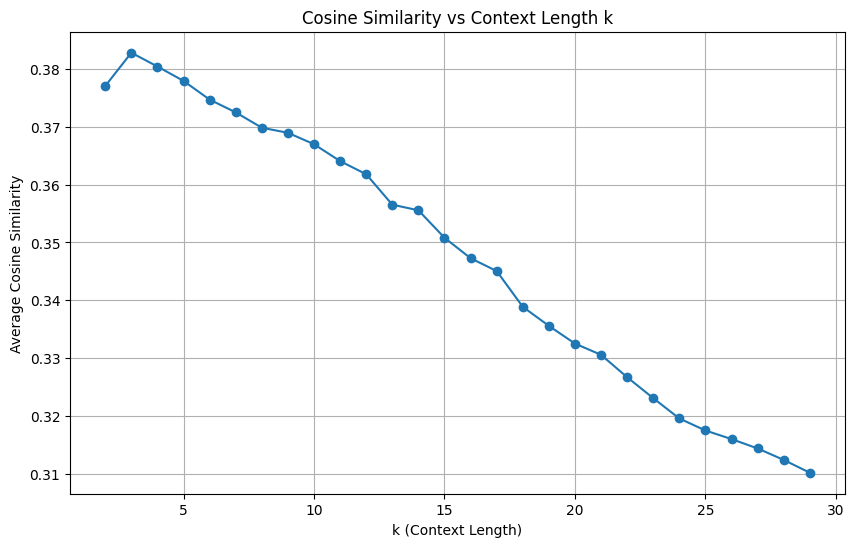

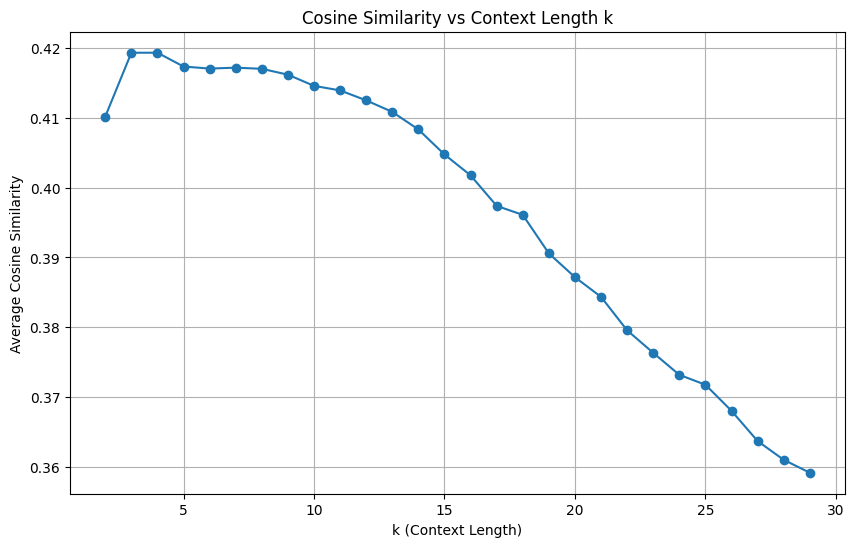

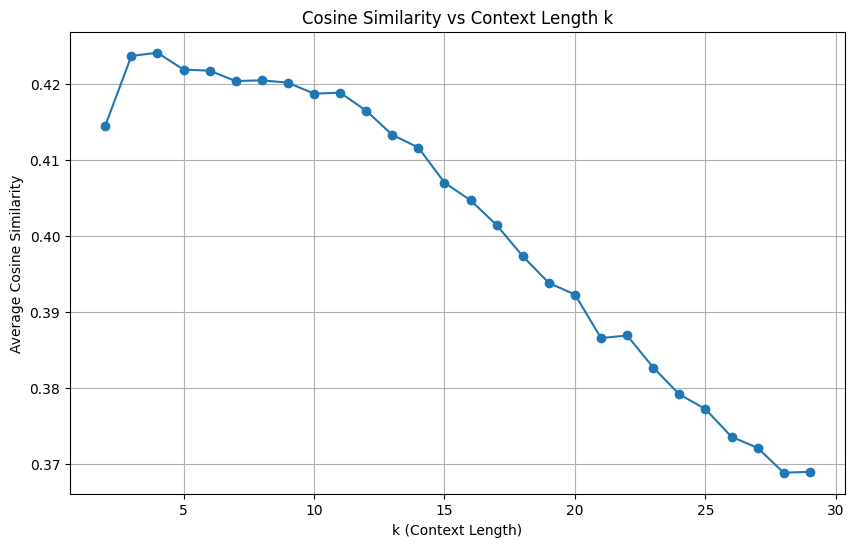

In [2]:
import gensim.downloader as api

# Load a pre-trained Word2Vec model (word2vec-google-news-300)
pretrained_w2v = api.load("word2vec-google-news-300")

questions_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/question.jsonl"
llama2_70b_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/Llama-2-70b-chat.jsonl"
gpt35_turbo_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-3.5-turbo.jsonl"
gpt4_path = "/home/mlyang721/SpeculativeCopying/dataset/mt-bench/data/mt_bench/model_answer/gpt-4.jsonl"


# Load datasets
questions = read_jsonl(questions_path)
llama2_70b_responses = read_jsonl(llama2_70b_path)
gpt35_turbo_responses = read_jsonl(gpt35_turbo_path)
gpt4_responses = read_jsonl(gpt4_path)

# Extract corpus from questions and responses
corpus_llama = extract_corpus(questions, llama2_70b_responses)
corpus_gpt35 = extract_corpus(questions, gpt35_turbo_responses)
corpus_gpt4 = extract_corpus(questions, gpt4_responses)


# Define k values to test
k_values = range(2, 30)  # Adjust the range as needed

# Train Word2Vec for different k values
models_llama = train_word2vec_for_k(corpus_llama, pretrained_w2v, k_values)
model_gpt35 = train_word2vec_for_k(corpus_gpt35, pretrained_w2v, k_values)
models_gpt4 = train_word2vec_for_k(corpus_gpt4, pretrained_w2v, k_values)

# Compute cosine similarity for each k value
results_llama = compute_cosine_similarity(models_llama, corpus_llama, k_values)
results_gpt35 = compute_cosine_similarity(model_gpt35, corpus_gpt35, k_values)
results_gpt4 = compute_cosine_similarity(models_gpt4, corpus_gpt4, k_values)

# Plot the results
plot_results(results_llama)
plot_results(results_gpt35)
plot_results(results_gpt4)
